In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
dataset = './keypoint.csv'
model_save_path = './model.keras'
tflite_save_path = './model.tflite'

In [3]:
X_set = np.loadtxt(dataset, delimiter = ',', dtype = 'float32', usecols = list(range(1, (21 * 2) + 1)))
y_set = np.loadtxt(dataset, delimiter = ',', dtype = 'int32', usecols = (0))

X_train, X_val_test, y_train, y_val_test = train_test_split(X_set, y_set, train_size = 0.7, random_state = 1204)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size = 0.3333, random_state = 1204)

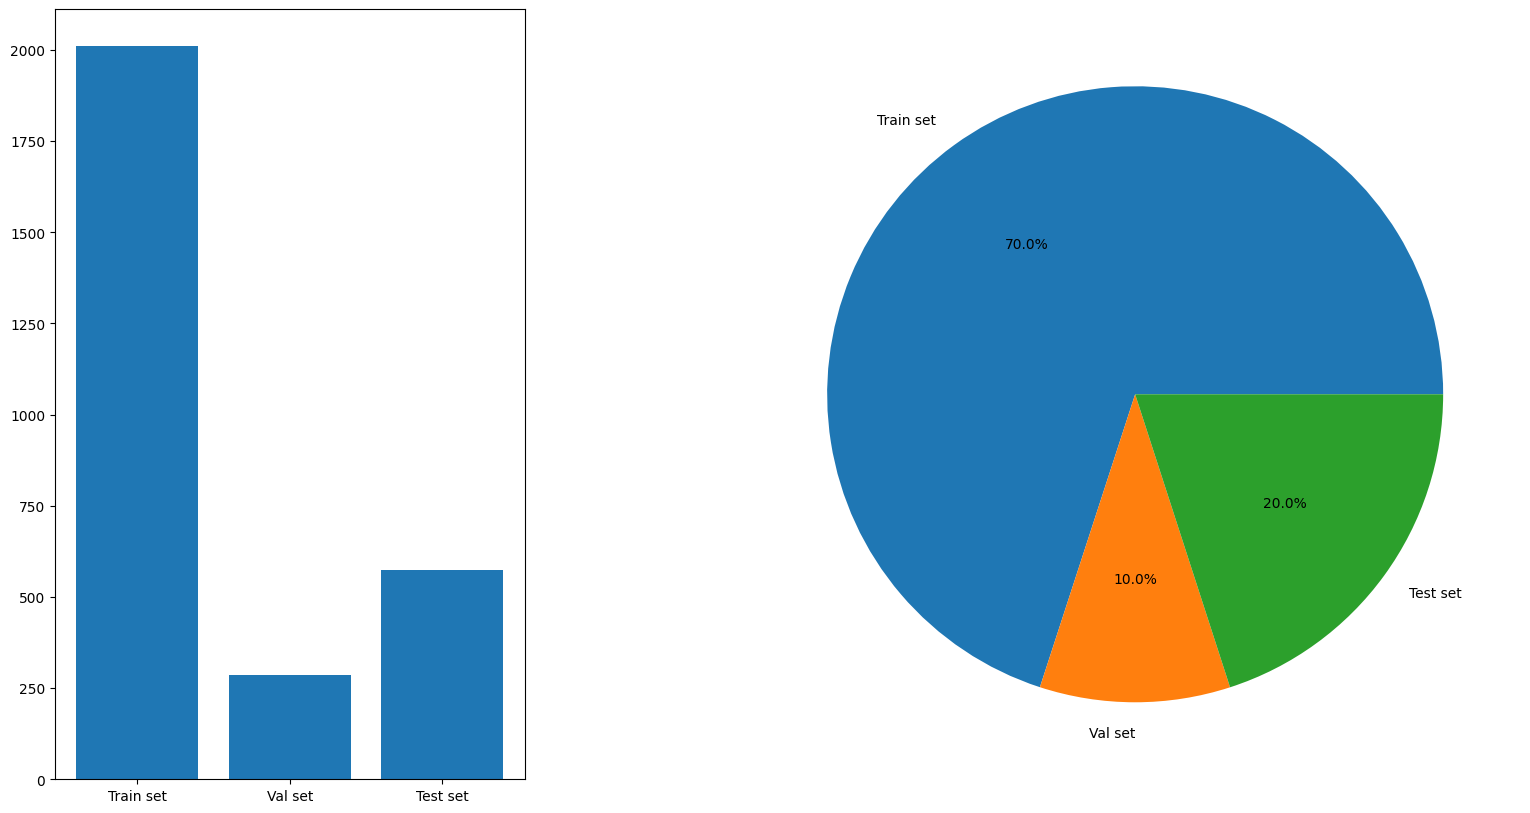

In [5]:
f, ax = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [1, 2]}, figsize = (20, 10))

ax[0].bar(['Train set', 'Val set', 'Test set'], [len(y_train), len(y_val), len(y_test)])


ax[1].pie([len(y_train), len(y_val), len(y_test)], labels = ['Train set', 'Val set', 'Test set'], autopct = '%1.1f%%')

plt.show()

# Model building

In [6]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Input((21 * 2,)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(20, activation = 'relu'),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Dense(10, activation = 'relu'),
                                    tf.keras.layers.Dense(len(pd.read_csv('./Label.csv', header = None)), activation = 'softmax')
                                   ])

model.compile(
                optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy']
             )

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose = 1, save_weights_only = False)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience = 20, verbose = 1)

In [9]:
model.compile(
                optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy']
             )

# Model training

In [10]:
model.fit(
            X_train,
            y_train,
            epochs = 1000,
            batch_size = 128,
            validation_data = (X_val, y_val),
            callbacks = [cp_callback, es_callback]
         )

Epoch 1/1000


 1/16 [>.............................] - ETA: 22s - loss: 1.9975 - accuracy: 0.1406
Epoch 1: saving model to .\model.keras
16/16 [==============================] - 2s 29ms/step - loss: 1.8561 - accuracy: 0.1711 - val_loss: 1.7541 - val_accuracy: 0.2439
Epoch 2/1000
 1/16 [>.............................] - ETA: 0s - loss: 1.8780 - accuracy: 0.1562
Epoch 2: saving model to .\model.keras
16/16 [==============================] - 0s 10ms/step - loss: 1.7764 - accuracy: 0.2337 - val_loss: 1.6912 - val_accuracy: 0.4181
Epoch 3/1000
 1/16 [>.............................] - ETA: 0s - loss: 1.7449 - accuracy: 0.2578
Epoch 3: saving model to .\model.keras
16/16 [==============================] - 0s 9ms/step - loss: 1.7109 - accuracy: 0.2974 - val_loss: 1.6285 - val_accuracy: 0.4878
Epoch 4/1000
 1/16 [>.............................] - ETA: 0s - loss: 1.7065 - accuracy: 0.2422
Epoch 4: saving model to .\model.keras
16/16 [==============================] - 0s 9ms/step - loss: 1.6613 

In [11]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size = 128)

5/5 [==============================] - 0s 3ms/step - loss: 0.0474 - accuracy: 0.9930


In [12]:
model = tf.keras.models.load_model(model_save_path)

# Confusion matrix

18/18 [==============================] - 0s 2ms/step


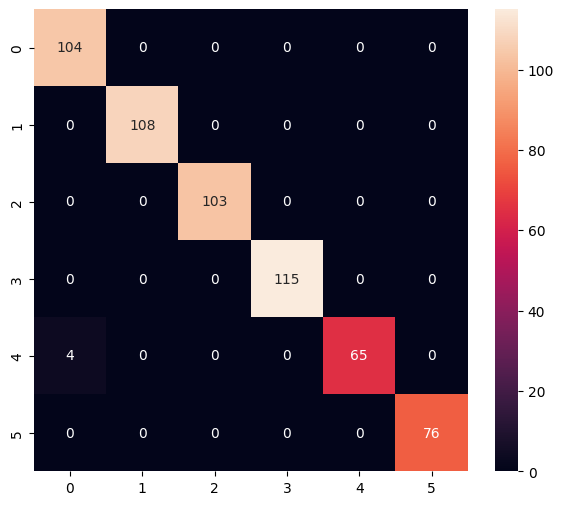

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       104
           1       1.00      1.00      1.00       108
           2       1.00      1.00      1.00       103
           3       1.00      1.00      1.00       115
           4       1.00      0.94      0.97        69
           5       1.00      1.00      1.00        76

    accuracy                           0.99       575
   macro avg       0.99      0.99      0.99       575
weighted avg       0.99      0.99      0.99       575



In [13]:
def print_confusion_matrix(y_true, y_pred, report = True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels = labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns = labels)
 
    fig, ax = plt.subplots(figsize = (7, 6))
    sns.heatmap(df_cmx, annot = True, fmt = 'g' ,square = False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis = 1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [14]:
model.save(model_save_path)

tf_callable = tf.function(model.call, autograph = False, input_signature = [tf.TensorSpec([None, 42], tf.float32)])
tf_concrete = tf_callable.get_concrete_function()

tflite_model = tf.lite.TFLiteConverter.from_concrete_functions([tf_concrete], tf_callable).convert()

open(tflite_save_path, 'wb').write(tflite_model)

6348